<a href="https://colab.research.google.com/github/MalavikaK/AirbnbAnalysis/blob/main/Lab1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import pdb
from google.colab import files

## FUNCTION

In [ ]:
class LinearRegression:
    def __init__(self, X,y,learningRate,tolerance,maxIteration,lamda=0.05,
                 batch_size=1,gd=False,reg=False,sgd=False)->None:
        self.X=X
        self.y=y
        self.tolerance=tolerance
        self.learningRate=learningRate
        self.maxIteration=maxIteration
        self.gd=gd
        self.lamda=lamda
        self.reg=reg
        self.sgd=sgd
        self.batch_size=batch_size
  
    def trainTestSplit(self):
        X_train,X_test,y_train,y_test=train_test_split(self.X,self.y,
                                                       test_size=0.3,
                                                       random_state=0)
        return X_train, X_test,y_train,y_test
    
    #Adding constant feature -- Columns of 1's
    def add_X0(self,X):
        return np.column_stack([np.ones([X.shape[0],1]),X]) 
        
    # Feed only the training dataset       
    def normalize(self,X):
        mean=np.mean(X,0)
        sd=np.std(X,0)
        X_norm=(X-mean)/sd
        X_norm=self.add_X0(X_norm)
        return X_norm, mean, sd
    
    # Using parameters of train to normalize test set
    def normalizeTestData(self, X, trainMean,trainSd):
        X_norm=(X-trainMean)/trainSd
        X_norm=self.add_X0(X_norm)
        return X_norm
    
    
    def rank(self,X,eps=1e-12):
      # singular value decomposition
        u,s,vh=np.linalg.svd(X)                                 
        #u, sigma, v transpose
        return "Rank : " + str (len([x for x in s if abs(x)>eps]) ) 
          #Return # of non-zero eigen values    


  # Check rank of matrix
    def checkMatrix(self,X):
        X_rank=np.linalg.matrix_rank(X)     
        if X_rank==min(X.shape[0],X.shape[1]):
            self.fullRank=True
            print("Data is Full Rank")
        else:
            self.fullRank=False
            print("Data is not Full Rank")
            
   #Check dimension greater than or less than rows 
    def checkInvertibility(self,X):
        if X.shape[0]<X.shape[1]:
            self.lowRank=True
            print("Data is low Rank")
        else:
            self.lowRank=False
            print("Data is not low Rank")
    
    def closedFormSolution(self,X,y,reg):
        if reg==False:
            w=np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)   
        else:
            #self.lamda=0.0001 ==> declared above
            w=np.linalg.inv(X.T.dot(X)+ 
                        self.lamda*(np.identity(X.shape[1]))).dot(X.T).dot(y)
        return w    
    
    def gradientDescent(self,X,y,reg):
        # storing error values to track , if it reduces
        errorSequences=[]
        last=float('inf')                        
        for t in tqdm(range(self.maxIteration)):    
          # can use trange instead of tqdm
            self.w=self.w-self.learningRate *self.costDerivative(X,y)
            cur=self.sse(X,y)
            diff=last-cur              
            last=cur
            errorSequences.append(cur)
            if abs(diff)< self.tolerance:
                print("The model stopped as error is too low and meets the stopping criteria")
                break
        self.plot(errorSequences)


    def stochasticGradientDescent(self,X,y):
        errorSequences=[]
        last=float('inf')                   
        sigma=0.0000001
        tao=0.01
        cur=0
        diff=0
        for t in tqdm(range(self.maxIteration)):            
            
  
            
            for i in range(0,X.shape[0],self.batch_size):
                Xk=X[i:i+self.batch_size,:]
                yk=y[i:i+self.batch_size]
                self.w=self.w - (self.learningRate* self.costDerivative(X,y))
            
            cur=self.sse(X,y)
            diff=last-cur          
            last=cur
            errorSequences.append(cur)

            if diff< self.tolerance:
                print("The model stopped -no further improvement")
                self.plot(errorSequences)
                break
        self.plot(errorSequences)
    def plot(self,errorSequences):
        plt.ticklabel_format(style='plain')
        
        plt.plot(errorSequences)
        plt.xlabel('Number of Iterations')
        plt.ylabel('Sum of Squared Error')
            

    
  
    def sse(self,X,y):
        y_hat=self.predict(X)
        return ((y_hat-y)**2).sum()
    
    #Predict Function
    
    def predict(self,X):
        return X.dot(self.w) #w is theta
    
       
    def rmse(self,X,y):
        y_hat=self.predict(X)
        return np.sqrt((((y_hat-y)**2)/X.shape[0]).sum())
    

    def costFunction(self,X,y):
        return self.rmse(X,y)/2
 
    
    def costDerivative(self,X,y):
        y_hat=self.predict(X)
        if self.reg==False:
            return (y_hat-y).dot(X)
        else:
            return (y_hat-y).dot(X)+(self.lamda * self.w)

            
        
    # IF else condition , based on closed form / Gradient descent / SGD
    def fit(self):
        
        self.X_train,self.X_test,self.y_train,self.y_test=self.trainTestSplit()
        self.X_train,self.mean,self.sd=self.normalize(self.X_train)
        self.X_test=self.normalizeTestData(self.X_test, self.mean, self.sd)
        
        self.checkMatrix(self.X_train)
        self.checkInvertibility(self.X_train)
        
        if self.fullRank and not self.lowRank and not self.gd and not self.sgd:
            print("Solving using closed form solution")
            self.w=self.closedFormSolution(self.X_train,self.y_train,self.reg)
            
        elif self.gd and not self.sgd:
            print("Solving using gradient descent")
            #initializing weights as 0
            self.w=np.ones(self.X_train.shape[1],dtype=np.float64)*0
            self.gradientDescent(self.X_train,self.y_train,self.reg)
        else:
            print("Solving using Stochastic Gradient Descent")
            #initializing weights as 0
            self.w=np.ones(self.X_train.shape[1],dtype=np.float64)*0
            self.stochasticGradientDescent(self.X_train,self.y_train)
        print("\n")
        print("Weights: "+str(self.w))
        print("Errors in train dataset:")
        print("\n")
        print("RMSE: "+str(self.rmse(self.X_train,self.y_train)))
        print("SSE: "+str(self.sse(self.X_train,self.y_train)))
        print("\n")
        print("Errors in test dataset:")
        print("RMSE: "+str(self.rmse(self.X_test,self.y_test)))
        print("SSE: "+str(self.sse(self.X_test,self.y_test)))
        
        
        

## HOUSING DATASET

In [ ]:
df1 = files.upload()

Saving housing.csv to housing (2).csv


In [ ]:
df=pd.read_csv("housing.csv",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


#### Closed Form Solution Without Regularization

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0004,tolerance=0.005, 
                              maxIteration=50000,gd=False,reg=False,sgd=False)
regression.fit()

Data is Full Rank
Data is not low Rank
Solving using closed form solution


Weights: [22.74548023 -1.01189299  1.05028731  0.07922238  0.61896311 -1.87367112
  2.70526765 -0.27955798 -3.09763515  2.09690865 -1.88608488 -2.26109811
  0.58264435 -3.44050512]
Errors in train dataset:


RMSE: 4.467466666510133
SSE: 7065.2234793982225


Errors in test dataset:
RMSE: 5.214973224911791
SSE: 4133.783751955127


Closed Form Solution With Regularization

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0004,tolerance=0.005, 
                              maxIteration=50000,gd=False,reg=True,sgd=False)
regression.fit()

Data is Full Rank
Data is not low Rank
Solving using closed form solution


Weights: [22.74226804 -1.01138347  1.04931903  0.07768688  0.61921281 -1.87170589
  2.70581139 -0.27986718 -3.09567209  2.09247089 -1.88192488 -2.26063174
  0.58265739 -3.4396972 ]
Errors in train dataset:


RMSE: 4.4674683055768485
SSE: 7065.228663712122


Errors in test dataset:
RMSE: 5.215373536249813
SSE: 4134.418410637462


Gradient Descent Solution without Regularization

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 363/50000 [00:00<00:01, 28063.56it/s]

The model stopped as error is too low and meets the stopping criteria


Weights: [22.74548023 -1.00695704  1.04172285  0.05071163  0.62307035 -1.86558657
  2.71080706 -0.28572203 -3.09874371  2.02599784 -1.80638574 -2.25793522
  0.58123396 -3.4382458 ]
Errors in train dataset:


RMSE: 4.467554276040867
SSE: 7065.500588117349


Errors in test dataset:
RMSE: 5.217879585785907
SSE: 4138.392640507719


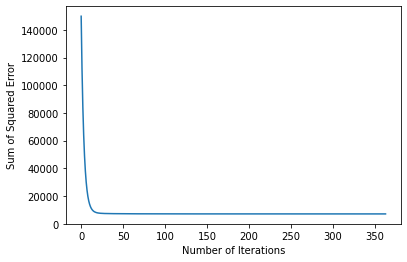

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0004,tolerance=0.005, 
                              maxIteration=50000,gd=True,reg=False,sgd=False)
regression.fit()

Gradient Descent Solution with Regularization

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 366/50000 [00:00<00:02, 23325.77it/s]

The model stopped as error is too low and meets the stopping criteria


Weights: [22.74226804 -1.00662561  1.0410636   0.05019691  0.62317274 -1.86392453
  2.71114901 -0.28580742 -3.09675029  2.02410088 -1.80507507 -2.25758458
  0.58129661 -3.43752063]
Errors in train dataset:


RMSE: 4.467559590681943
SSE: 7065.517398488152


Errors in test dataset:
RMSE: 5.218178539229494
SSE: 4138.866864625839


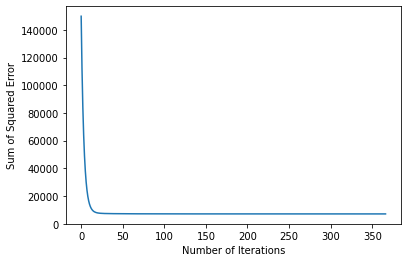

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0004,tolerance=0.005, 
                              maxIteration=50000,gd=True,reg=True,sgd=False)
regression.fit()

Stochastic Gradient Descent without Regularization

Data is Full Rank
Data is not low Rank
Solving using Stochastic Gradient Descent


  0%|          | 2/50000 [00:00<10:06, 82.45it/s]

The model stopped -no further improvement


Weights: [22.74548023 -1.0118834   1.05027065  0.07916664  0.61897113 -1.87365598
  2.70527832 -0.27956986 -3.09763772  2.09677005 -1.8859288  -2.26109205
  0.58264155 -3.4405008 ]
Errors in train dataset:


RMSE: 4.467466666845255
SSE: 7065.223480458204


Errors in test dataset:
RMSE: 5.214978733278881
SSE: 4133.7924846597525


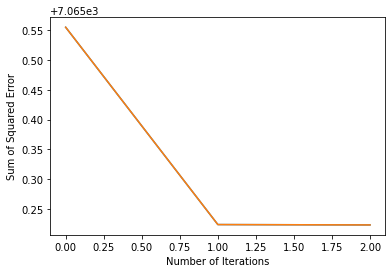

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0004,tolerance=0.005, 
                              maxIteration=50000,gd=False,reg=False,sgd=True)
regression.fit()

Stochastic Gradient Descent With Regularization

Data is Full Rank
Data is not low Rank
Solving using Stochastic Gradient Descent


  0%|          | 2/50000 [00:00<13:36, 61.26it/s]

The model stopped -no further improvement


Weights: [22.74226804 -1.0113741   1.04930276  0.07763244  0.61922064 -1.8716911
  2.70582181 -0.27987878 -3.0956746   2.09233554 -1.88177246 -2.26062583
  0.58265465 -3.43969298]
Errors in train dataset:


RMSE: 4.46746832530703
SSE: 7065.228726118047


Errors in test dataset:
RMSE: 5.215378927279644
SSE: 4134.42695797711


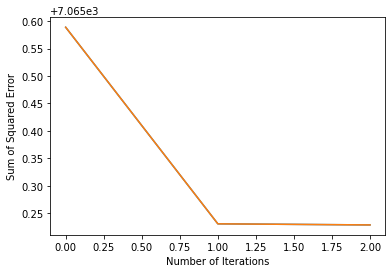

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0004,tolerance=0.005, 
                              maxIteration=50000,gd=False,reg=True,sgd=True)
regression.fit()

## YACHT DATASET

In [ ]:
df1 = files.upload()

Saving yachtData.csv to yachtData (1).csv


In [ ]:
df=pd.read_csv("yachtData.csv",header=None)
df.head()

,0,1,2,3,4,5,6
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


#### Closed Form Solution Without Regularization

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.001,tolerance=0.001, 
                              maxIteration=50000,gd=False,reg=False,sgd=False)
regression.fit()

Data is Full Rank
Data is not low Rank
Solving using closed form solution


Weights: [11.23939535  0.81790302  0.20369276  2.97602416 -2.75890138 -3.83325201
 12.9328097 ]
Errors in train dataset:


RMSE: 9.012054802825176
SSE: 17461.68333036173


Errors in test dataset:
RMSE: 8.80194763079057
SSE: 7205.108234851716


Closed Form Solution With Regularization

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.001,tolerance=0.001, 
                              maxIteration=50000,gd=False,reg=True,sgd=False)
regression.fit()

Data is Full Rank
Data is not low Rank
Solving using closed form solution


Weights: [11.23678214  0.81680196  0.17633658  2.86658621 -2.66966448 -3.72735065
 12.92972981]
Errors in train dataset:


RMSE: 9.012067983955912
SSE: 17461.734409700286


Errors in test dataset:
RMSE: 8.798801622331327
SSE: 7199.958628990056


Gradient Descent Solution without Regularization

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  3%|▎         | 1643/50000 [00:00<00:01, 46397.86it/s]

The model stopped as error is too low and meets the stopping criteria


Weights: [11.23939535  0.81522178  0.13102656  2.68675502 -2.5228081  -3.55339498
 12.93260437]
Errors in train dataset:


RMSE: 9.012140777905929
SSE: 17462.016501170903


Errors in test dataset:
RMSE: 8.796248628280743
SSE: 7195.78106353937


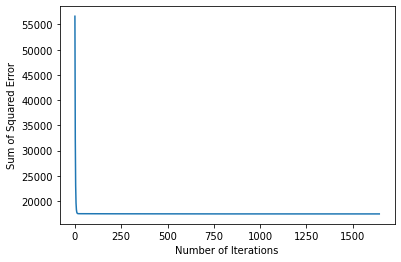

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.001,tolerance=0.001, 
                              maxIteration=50000,gd=True,reg=False,sgd=False)
regression.fit()

Gradient Descent Solution with Regularization

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  3%|▎         | 1702/50000 [00:00<00:01, 37647.03it/s]

The model stopped as error is too low and meets the stopping criteria


Weights: [11.23678214  0.81462076  0.11722244  2.63126503 -2.477602   -3.49968625
 12.92956278]
Errors in train dataset:


RMSE: 9.012177787999722
SSE: 17462.159923740848


Errors in test dataset:
RMSE: 8.79421819084816
SSE: 7192.459443706753


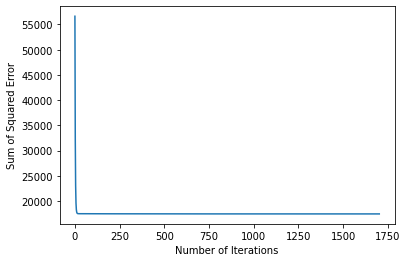

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.001,tolerance=0.001, 
                              maxIteration=50000,gd=True,reg=True,sgd=False)
regression.fit()

Stochastic Gradient Descent without Regularization

Data is Full Rank
Data is not low Rank
Solving using Stochastic Gradient Descent


  0%|          | 16/50000 [00:00<02:07, 393.22it/s]

The model stopped -no further improvement


Weights: [11.23939535  0.81777038  0.20009812  2.96171465 -2.74722236 -3.81940809
 12.93279955]
Errors in train dataset:


RMSE: 9.012055013212711
SSE: 17461.684145652063


Errors in test dataset:
RMSE: 8.801660285791135
SSE: 7204.637812141976


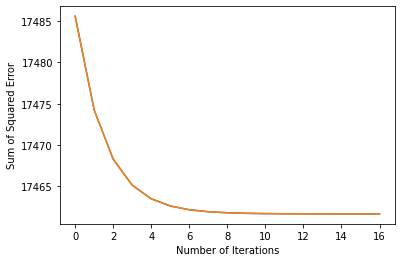

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.001,tolerance=0.001, 
                              maxIteration=50000,gd=False,reg=False,sgd=True)
regression.fit()

Stochastic Gradient Descent With Regularization

Data is Full Rank
Data is not low Rank
Solving using Stochastic Gradient Descent


  0%|          | 21/50000 [00:00<02:14, 370.73it/s]

The model stopped -no further improvement


Weights: [11.23678214  0.81678165  0.17578637  2.86439594 -2.66787685 -3.72523165
 12.92972826]
Errors in train dataset:


RMSE: 9.012068481324068
SSE: 17461.73633709606


Errors in test dataset:
RMSE: 8.798758256824458
SSE: 7199.887658169402


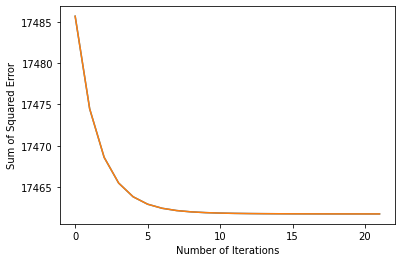

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.001,tolerance=0.001, 
                              maxIteration=50000,gd=False,reg=True,sgd=True)
regression.fit()

## CONCRETE DATASET

In [ ]:
df1 = files.upload()

Saving concreteData.csv to concreteData (1).csv


In [ ]:
df=pd.read_csv("concreteData.csv",header=None)
df.head()

,0,1,2,3,4,5,6,7,8
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


#### Closed Form Solution Without Regularization

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0007,tolerance=0.0001, 
                              maxIteration=50000,gd=False,reg=False,sgd=False)
regression.fit()

Data is Full Rank
Data is not low Rank
Solving using closed form solution


Weights: [35.85368932 12.72547471  9.54463305  5.99752761 -2.82130272  2.10540297
  1.85195151  1.95023318  7.17433735]
Errors in train dataset:


RMSE: 10.64860379952002
SSE: 81756.18203586874


Errors in test dataset:
RMSE: 9.67567754660951
SSE: 28928.189419662704


Closed Form Solution With Regularization

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0007,tolerance=0.0001, 
                              maxIteration=50000,gd=False,reg=True,sgd=False)
regression.fit()

Data is Full Rank
Data is not low Rank
Solving using closed form solution


Weights: [35.85120311 12.71207657  9.53125197  5.98554438 -2.83037146  2.10528716
  1.84262708  1.93830462  7.17327795]
Errors in train dataset:


RMSE: 10.648605366388999
SSE: 81756.20609559288


Errors in test dataset:
RMSE: 9.675713091328245
SSE: 28928.401962141535


Gradient Descent Solution without Regularization

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 440/50000 [00:00<00:02, 19852.56it/s]

The model stopped as error is too low and meets the stopping criteria


Weights: [35.85368932 12.72033523  9.53947715  5.99298714 -2.82570188  2.10479451
  1.84789054  1.94520372  7.17419989]
Errors in train dataset:


RMSE: 10.648603997670376
SSE: 81756.1850785243


Errors in test dataset:
RMSE: 9.675565408239933
SSE: 28927.51888446092


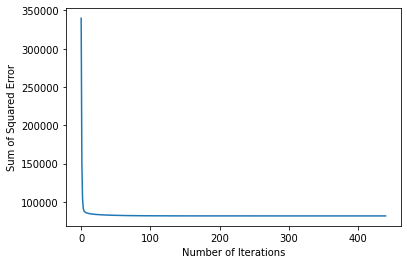

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0007,tolerance=0.0001, 
                              maxIteration=50000,gd=True,reg=False,sgd=False)
regression.fit()

Gradient Descent Solution with Regularization

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 503/50000 [00:00<00:01, 33068.46it/s]

The model stopped as error is too low and meets the stopping criteria


Weights: [35.85120311 12.71022503  9.52939453  5.98390864 -2.83195628  2.10506796
  1.84116409  1.93649273  7.17322843]
Errors in train dataset:


RMSE: 10.648605740977416
SSE: 81756.21184750636


Errors in test dataset:
RMSE: 9.675672951611606
SSE: 28928.16194356347


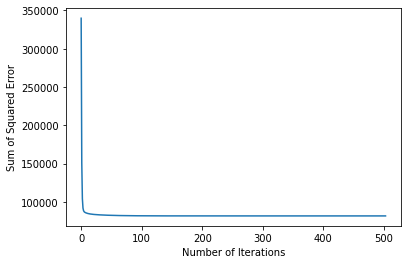

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0007,tolerance=0.0001, 
                              maxIteration=50000,gd=True,reg=True,sgd=False)
regression.fit()

Stochastic Gradient Descent without Regularization

Data is Full Rank
Data is not low Rank
Solving using Stochastic Gradient Descent


  0%|          | 1/50000 [00:00<27:44, 30.04it/s]

The model stopped -no further improvement


Weights: [35.85368932 12.72547471  9.54463304  5.99752761 -2.82130272  2.10540297
  1.85195151  1.95023318  7.17433735]
Errors in train dataset:


RMSE: 10.64860379952002
SSE: 81756.18203586873


Errors in test dataset:
RMSE: 9.67567754659556
SSE: 28928.18941957929


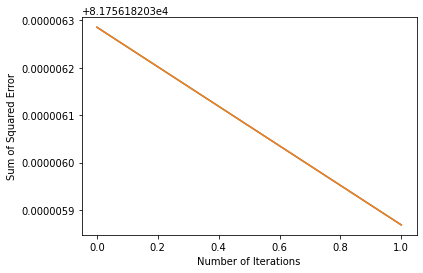

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0007,tolerance=0.0001, 
                              maxIteration=50000,gd=False,reg=False,sgd=True)
regression.fit()

Stochastic Gradient Descent With Regularization

Data is Full Rank
Data is not low Rank
Solving using Stochastic Gradient Descent


  0%|          | 2/50000 [00:00<18:33, 44.92it/s]

The model stopped -no further improvement


Weights: [35.85120311 12.71207657  9.53125197  5.98554438 -2.83037146  2.10528716
  1.84262708  1.93830462  7.17327795]
Errors in train dataset:


RMSE: 10.648605366388999
SSE: 81756.20609559288


Errors in test dataset:
RMSE: 9.675713091328241
SSE: 28928.401962141525


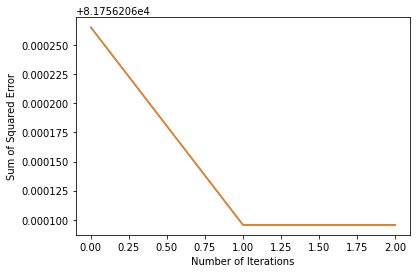

In [ ]:
regression = LinearRegression(df.values[:,0:-1],df.values[:,-1],
                              learningRate=0.0007,tolerance=0.0001, 
                              maxIteration=50000,gd=False,reg=True,sgd=True)
regression.fit()

## Effect of Learning Rate (alpha)


If Learning Rate (alpha) is too large:
The tetha optimal will keep bouncing around the cost function curve , and never reach the minima. This operation would be terminated at the stopping criteria of max iterations(in this case)

If Learning Rate (alpha) is too low:
The rate of change will be so little that , it might take forever to converge into the minima 

## Effect of Regulariztion Parameter (lambda)



If Regularization Parameter (lamda) is too large (e.g.: 1000):
With a big lambda value, the total cost function would try to adjust itself, hence resulting in a Theta optimal that is far away from the actual optimal value , this leads to underfitting

If Regularization Parameter (lamda) is too small (e.g.: 0.00001):
There will be no/very little effect of lambda on the model. This would be equivaent to eliminating the regularization parameter. This means, it would still lead to overfitting